In [31]:
import math
import numpy as np
from abc import ABC, abstractmethod
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from nis_new_main_class import *
import os
import glob
import random, shutil

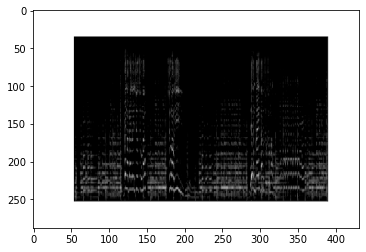

(288, 432)

In [32]:
img_blue1 = cv2.imread('CNN_data/blues00005.png', cv2.IMREAD_GRAYSCALE)/255
# image=cv2.resize(img_blue1, (64, 64),interpolation = cv2.INTER_AREA)
plt.imshow(img_blue1,cmap='gray')
plt.show()
img_blue1.shape

In [33]:
class Layer(ABC) :
    def __init__(self):
        self.prevIn = []
        self.prevOut = []
    
    def setPrevIn(self, dataIn):
        self.prevIn = dataIn
        
    def setPrevOut(self, out):
        self.prevOut = out
        
    def getPrevIn(self):
        return self.prevIn
    
    def getPrevOut(self):
        return self.prevOut
    
    def backward(self, gradIn):
        sg = self.gradient()
        grad = np.zeros((gradIn.shape[0],sg.shape[2]))
        for n in range(gradIn.shape[0]): #compute for each observation in batch
            grad[n,:] = gradIn[n,:]@sg[n,:,:]
        return grad
    
    @abstractmethod
    def forward(self, dataIn):
        pass
    
    @abstractmethod
    def gradient(self):
        pass


In [34]:
class InputLayer(Layer):
    def __init__(self, dataIn):
        super().__init__()
        self.meanX = np.mean(dataIn, axis=0)
        self.stdX = np.std(dataIn, axis=0, ddof=1)
        self.stdX[self.stdX == 0] = 1
        
    
    def forward(self, dataIn):
        self.setPrevIn(dataIn)
        Y = (dataIn - self.meanX) / self.stdX
        self.setPrevOut(Y)
        return Y

    def gradient(self):
        pass


In [35]:
class ConvolutionLayer(Layer):
    def __init__(self, num_filters=3, filter_size=3):
        super().__init__()
        np.random.seed(0)
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filter = np.random.randn(num_filters,filter_size,filter_size)/(filter_size*filter_size)
        
    def image_region(self,image):
        height,width = image.shape
        self.image = image
        for j in range(height - self.filter_size + 1):
            for k in range(width - self.filter_size + 1):
                img_area = image[ j : (j + self.filter_size), k : (k + self.filter_size)]
                yield img_area,j, k
                
    def forward(self, image):
        self.setPrevIn(image)
        self.image = image
        height,width = image.shape

        output_hdim = height - self.filter_size + 1
        output_wdim = width - self.filter_size + 1
        conv_out = np.zeros((output_hdim, output_wdim, self.num_filters))   
        temp_x = temp_y = 0
        for img_area,i,j in self.image_region(image): 
            conv_out[i,j] = np.sum(img_area * self.filter, axis = (1,2))        
        self.setPrevOut(conv_out)
        return conv_out
    
    def getFilter(self):
        return self.filter

    def setFilter(self, vfilter):
        self.filter = vfilter
        
    def updateFilters(self, gradIn, eta = 0.001):
        dJdF = np.zeros(self.filter.shape)
        #X conv(*) with gradIn
        for img_area,i,j in self.image_region(self.image):
            for k in range(self.num_filters):
                dJdF[k] += img_area * gradIn[i,j,k]
    
        self.filter -= eta*dJdF
        return self.filter
    
    def gradient(self):
        pass
    
    def backward(self, gradIn):
        input_hdim = self.getPrevIn().shape[0]
        input_wdim = self.getPrevIn().shape[1]  
        grad = np.zeros(self.getPrevIn().shape)           
        for f in range(self.filter.shape[0]):
            tmp_y = out_y = 0
            while tmp_y + self.filter_size <= input_hdim:
                tmp_x = out_x = 0
                while tmp_x + self.filter_size <= input_wdim:
                    grad[tmp_y:tmp_y + self.filter_size, tmp_x:tmp_x + self.filter_size] += gradIn[out_y, out_x,f] * self.filter[f]
                    tmp_x += 1
                    out_x += 1
                tmp_y += 1
                out_y += 1

        
        return grad                 

In [36]:
class MaxPoolLayer(Layer):
    def __init__(self,pool_size=3,stride = 1):
        super().__init__()
        self.pool_size = pool_size
        self.stride = stride
    
    def forward(self, image):
        self.setPrevIn(image)
        self.image = image
        h_prev, w_prev, num_pools = image.shape
        h = int((h_prev - self.pool_size) / self.stride) + 1     
        w = int((w_prev - self.pool_size) / self.stride) + 1
        out = np.zeros((h,w,num_pools))
        
        for i in range(num_pools):                      
            curr_y = out_y = 0                             
            while curr_y + self.pool_size <= h_prev:  # slide the max pooling window vertically across the image
                curr_x = out_x = 0
                while curr_x + self.pool_size <= w_prev:   # slide the max pooling window horizontally across the image
                    img_area = image[curr_y:curr_y + self.pool_size, curr_x:curr_x + self.pool_size,i]
                    out[out_y, out_x, i] = np.max(img_area)    # choose the maximum value within the window
                    curr_x += self.stride                       
                    out_x += 1
                curr_y += self.stride
                out_y += 1
        self.setPrevOut(out)
        return out
    
    def backward(self,gradIn):
        h, w, num_pools= self.getPrevIn().shape                                                                 
        grad = np.zeros((h, w, num_pools))

        for c in range(num_pools):
            tmp_y = out_y = 0
            while tmp_y + self.pool_size <= h:
                tmp_x = out_x = 0
                while tmp_x + self.pool_size <= w:
                    patch = self.image[tmp_y:tmp_y + self.pool_size, tmp_x:tmp_x + self.pool_size,c]   
                    (x, y) = np.unravel_index(np.nanargmax(patch), patch.shape)          
                    grad[tmp_y + x, tmp_x + y,c] += gradIn[out_y, out_x,c]
                    tmp_x += self.stride
                    out_x += 1
                tmp_y += self.stride
                out_y += 1
        return grad
    
    def gradient(self):
            pass
        

In [37]:
class FlatteningLayer(Layer):
    def __init__(self):
        super().__init__()
        
    def forward(self, image):
        self.setPrevIn(image)
        modified_image = image.flatten()
        modified_image = modified_image.reshape(1,len(modified_image))
        self.setPrevOut(modified_image)
        return modified_image
    
    def backward(self,gradIn):
        grad = gradIn.reshape(self.getPrevIn().shape)
        return grad
    
    def gradient(self):
        pass

In [38]:
class ReLuLayer(Layer):
    def __init__(self):
        super().__init__()       
    
    def forward(self, dataIn):    
        self.setPrevIn(dataIn)
        Y = np.copy(dataIn)
        Y[Y < 0] = 0   
        self.setPrevOut(Y)
        return Y

    def gradient(self):
        n = self.getPrevIn().shape[0]
        
        k = self.getPrevIn().shape[1]
        relu_gradient = np.zeros(shape=(n,k,k))
        
        for g in range(n):
            X = [0 if i < 0 else 1 for i in self.getPrevIn()[g]]
            np.fill_diagonal(relu_gradient[g], X)
        
        return (relu_gradient)

In [39]:
class SigmoidLayer(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, dataIn):
        self.setPrevIn(dataIn)
        Y = 1/(1+np.exp(-dataIn))
        self.setPrevOut(Y)
        return Y

    def gradient(self):
        n = self.getPrevOut().shape[0]     
        k = self.getPrevOut().shape[1]
        sigmoid_gradient = np.zeros(shape=(n,k,k))
        
        for g in range(n):
            X = self.getPrevOut()[g] * (1 - self.getPrevOut()[g]) + 10**-7
            np.fill_diagonal(sigmoid_gradient[g], X)
        
        return (sigmoid_gradient)

In [40]:
class SoftmaxLayer(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, dataIn):
        self.setPrevIn(dataIn)
        out = np.exp(dataIn)
        if out.ndim !=1:
            denom = np.sum(out,axis=1).tolist()
        else:
            denom = np.sum(out)
        
        for i in range(out.shape[0]):
            if out.ndim != 1:
                
                out[i] = out[i]/denom[i]   
            else:
                out[i] = out[i]/denom
            
        self.setPrevOut(out)
        return out

    def gradient(self):
        
        n = self.getPrevOut().shape[0]     
        k = self.getPrevOut().shape[1]
        softmax_gradient = np.zeros(shape=(n,k,k))
        
        for g in range(n):
            gz = np.copy(self.getPrevOut()[g])
            for i in range(len(self.getPrevOut()[g])):
                for j in range(len(self.getPrevOut()[g])):
                    if i==j:
                        softmax_gradient[g][i][j] = gz[i] * (1-gz[i])
                    else:
                        softmax_gradient[g][i][j] = -gz[i] * gz[j]     
            
        return (softmax_gradient)

In [41]:
class TanhLayer(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, dataIn):
        self.setPrevIn(dataIn)
        Y = (np.exp(dataIn) - np.exp(-dataIn)) / (np.exp(dataIn) + np.exp(-dataIn))
        self.setPrevOut(Y)
        return Y

    def gradient(self):
        n = self.getPrevOut().shape[0]     
        k = self.getPrevOut().shape[1]
        tanh_gradient = np.zeros(shape=(n,k,k))
        
        for g in range(n):
            X = 1 - (self.getPrevOut()[g]**2) + 10**-7   #epsilon = 10^(-7)
            np.fill_diagonal(tanh_gradient[g], X)

        return (tanh_gradient)

In [42]:
class FullyConnectedLayer(Layer):

    def __init__(self, sizeIn, sizeOut):
        super().__init__()
        np.random.seed(0)
        self.weights = np.random.uniform(
            size=(sizeIn, sizeOut), low=-0.0001, high=0.0001)
        self.bias = np.random.uniform(
            size=(1, sizeOut), low=-0.0001, high=0.0001)
        self.sw = 0
        self.rw = 0
        self.sb = 0
        self.rb = 0
    
    def getWeights(self):
        return self.weights

    def setWeights(self, weights):
        self.weights = weights

    def getBias(self):
        return self.bias

    def setBias(self, bias):
        self.bias = bias
        
    def getSB(self):
        return self.sb

    def setSB(self, sb):
        self.sb = sb

    def getRB(self):
        return self.rb

    def setRB(self, rb):
        self.rb = rb

    def getSW(self):
        return self.sw

    def setSW(self, sw):
        self.sw = sw

    def getRW(self):
        return self.rw

    def setRW(self, rw):
        self.rw = rw

    def forward(self, dataIn):
        self.setPrevIn(dataIn)
        Y = dataIn.dot(self.getWeights()) + self.getBias()
        self.setPrevOut(Y)
        return Y

    def gradient(self):
        X = np.copy(self.getWeights())
        return np.transpose(X)
    
    def updateWeights(self, gradIn, eta = 0.0001):
        dJdb = np.sum(gradIn, axis = 0)/gradIn.shape[0]
        dJdW = (self.getPrevIn().T @ gradIn)/gradIn.shape[0]
        self.weights -= eta*dJdW
        self.bias -= eta*dJdb
        return self.weights, self.bias
    
    def updateWeightsAdam(self, gradIn, eta, t, p_1=0.9, p_2=0.9999, delta=10**-8):
        dJdb = np.sum(gradIn, axis=0)/gradIn.shape[0]
        dJdW = (self.getPrevIn().T @ gradIn)/gradIn.shape[0]

        self.sw = p_1 * self.sw + (1 - p_1) * dJdW
        self.rw = p_2 * self.rw + (1 - p_2) * np.power(dJdW, 2)
        sw_hat = self.sw / (1 - np.power(p_1, t))
        rw_hat = self.rw / (1 - np.power(p_2, t))

        self.weights -= eta * (sw_hat / (np.sqrt(rw_hat) + delta))

        self.sb = p_1 * self.sb + (1 - p_1) * dJdb
        self.rb = p_2 * self.rb + (1 - p_2) * np.power(dJdb, 2)
        sb_hat = self.sb / (1 - np.power(p_1, t))
        rb_hat = self.rb / (1 - np.power(p_2, t))
        self.bias -= eta * (sb_hat / (np.sqrt(rb_hat) + delta))
        return self.weights, self.bias, self.sw, self.rw, self.sb, self.rb
        
    def backward(self,gradIn):
        W = np.copy(self.getWeights())
        fcc_grad = gradIn @ np.transpose(W)
        return fcc_grad

In [43]:
class LogLoss():
    def eval(self,y,yhat):
        e = 10**-7
        return np.mean(-(y * np.log(yhat + e) + ((1-y) * np.log(1-yhat+e))))
    
    def gradient(self,y,yhat):
        e = 10**-7
        return -((y-yhat)/(yhat*(1-yhat)+e))

In [44]:
class CrossEntropy():
    def eval(self,y,yhat):
        e = 10**-7
        
        temp = np.multiply(y,np.log(yhat))
        return np.mean(-(np.sum(temp) + e))
    
    def gradient(self,y,yhat):
        e = 10**-7
        return -(y/(np.array(yhat)+e))

In [51]:
# Create folder with training, testing and validation data.

spectrograms_dir = "Data/images_original/"
folder_names = ['Data/train/', 'Data/test/', 'Data/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

for f in folder_names:
    if os.path.exists(f):
        shutil.rmtree(f)
        os.mkdir(f)
    else:
        os.mkdir(f)

# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
    src_file_paths= []
    for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
        src_file_paths.append(im)
    random.shuffle(src_file_paths)
    test_files = src_file_paths[0:10]
    val_files = src_file_paths[10:20]
    train_files = src_file_paths[20:]

  #  make destination folders for train and test images
    for f in folder_names:
        if not os.path.exists(os.path.join(f + f"{g}")):
            os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
    for f in train_files:
        shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
    for f in test_files:
        shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
    for f in val_files:
        shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))

In [52]:
IMG_WIDTH=64
IMG_HEIGHT=64
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):     
        path = img_folder + dir1
        for file in glob.glob(os.path.join(path, '*.png')):

            image_path = file
            image= cv2.imread( image_path, cv2.IMREAD_GRAYSCALE)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name
# extract the image array and class name
img_data, class_name =create_dataset(train_dir)
img_val_data, class_val_name = create_dataset(val_dir)

In [53]:
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_dict

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [54]:
target_train=  [target_dict[class_name[i]] for i in range(len(class_name))]
target_val=  [target_dict[class_name[i]] for i in range(len(class_val_name))]

In [55]:
X_train=np.array(img_data, np.float32)
y_train = np.array(list(map(int,target_train)), np.float32).reshape(len(target_train),1)

X_val=np.array(img_val_data, np.float32)
y_val = np.array(list(map(int,target_val)), np.float32).reshape(len(target_val),1)

In [56]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(799, 64, 64)
(799, 1)
(100, 64, 64)
(100, 1)


In [57]:
def one_hot_encoding(data, classes):
    y_hot = np.zeros((len(data), classes))
    for i in np.arange(len(data)):
        i = int(i)
        
        col = int(data[i][0])
        y_hot[i][col] = 1
    return y_hot
y_train = one_hot_encoding(y_train,10)
y_val = one_hot_encoding(y_val,10)
print(y_train.shape)
print(y_val.shape)

(799, 10)
(100, 10)


In [58]:
X_train = X_train[:100,:,:]
y_train = y_train[:100,:]

X_val = X_val[:10,:,:]
y_val = y_val[:10,:]


In [59]:
def CNN(X_train,y_train,X_val,y_val,learning_rate = 0.01,epoch = 2):
    conv3 = ConvolutionLayer(28,11)  
    pool3 = MaxPoolLayer(7,5)  
    flatten3 = FlatteningLayer() 
    FCL3 = FullyConnectedLayer(2800,64)
    relu3 = ReLuLayer()   
    FCL4 = FullyConnectedLayer(64,32)
    relu4 = ReLuLayer()  
    FCL5 = FullyConnectedLayer(32,10)
    softmax3 = SoftmaxLayer()   
    ce3 = CrossEntropy()
    loss_train = []
    loss = []
    y_pred = np.zeros(shape=y_train.shape) 
    
    
    conv3_v = ConvolutionLayer(28,11)   
    pool3_v = MaxPoolLayer(7,5)   
    flatten3_v = FlatteningLayer() 
    FCL3_v = FullyConnectedLayer(2800,64)
    relu3_v = ReLuLayer()  
    FCL4_v = FullyConnectedLayer(64,32)
    relu4_v = ReLuLayer()   
    FCL5_v = FullyConnectedLayer(32,10)
    softmax3_v = SoftmaxLayer()  
    ce3_v = CrossEntropy()
    loss_val = []
    loss_v = []
    y_pred_v = np.zeros(shape=y_val.shape)
    
    for i in range(epoch):
        shuffle_data = np.random.permutation(len(X_train))
        X_new_train = X_train[shuffle_data]
        y_new_train = y_train[shuffle_data]
        
        for j,k in zip(X_new_train,y_new_train):
            c=0
            conv3_fwd = conv3.forward(j)
            pool3_fwd = pool3.forward(conv3_fwd)
            flatten3_fwd = flatten3.forward(pool3_fwd)
            FCL3_fwd = FCL3.forward(flatten3_fwd)
            relu3_fwd = relu3.forward(FCL3_fwd)
            FCL4_fwd = FCL4.forward(relu3_fwd)
            relu4_fwd = relu4.forward(FCL4_fwd)
            FCL5_fwd = FCL5.forward(relu4_fwd)
            softmax3_fwd = softmax3.forward(FCL5_fwd)
            
            ce3_out = ce3.eval(k,softmax3_fwd)
            loss_train.append(ce3_out)
            if i==epoch-1:
                y_pred[c] = softmax3_fwd
                
            c+=1
            
            ce_grad = ce3.gradient(k,softmax3_fwd)
            smax_grad = softmax3.backward(ce_grad)
            FCL5_grad = FCL5.backward(smax_grad)
            w5,b5 = FCL5.updateWeights(smax_grad,eta = learning_rate)
            relu4_grad = relu4.backward(FCL5_grad)
            FCL4_grad = FCL4.backward(relu4_grad)
            w4, b4= FCL4.updateWeights(relu4_grad,eta = learning_rate)
            relu3_grad = relu3.backward(FCL4_grad)
            FCL3_grad = FCL3.backward(relu3_grad)
            w3, b3 = FCL3.updateWeights(relu3_grad,eta = learning_rate)
            flatten_grad = flatten3.backward(FCL3_grad)
            pool3_grad = pool3.backward(flatten_grad)
            conv3_grad = conv3.backward(pool3_grad)
            f3 = conv3.updateFilters(pool3_grad,eta = learning_rate)
            
        loss.append(np.mean(loss_train))      
           
        shuffle_data_v = np.random.permutation(len(X_val))
        X_new_val = X_val[shuffle_data_v]
        y_new_val = y_val[shuffle_data_v]
        
        for p,q in zip(X_new_val,y_new_val):
            d=0
            conv3_v_fwd = conv3_v.forward(p)
            pool3_v_fwd = pool3_v.forward(conv3_v_fwd)
            flatten3_v_fwd = flatten3_v.forward(pool3_v_fwd)
            FCL3_v_fwd = FCL3_v.forward(flatten3_v_fwd)
            relu3_v_fwd = relu3_v.forward(FCL3_v_fwd)
            FCL4_v_fwd = FCL4_v.forward(relu3_v_fwd)
            relu4_v_fwd = relu4_v.forward(FCL4_v_fwd)
            FCL5_v_fwd = FCL5_v.forward(relu4_v_fwd)
            softmax3_v_fwd = softmax3_v.forward(FCL5_v_fwd)
            
            ce3_v_out = ce3_v.eval(q,softmax3_v_fwd)
            loss_val.append(ce3_v_out)
            if i==epoch-1:
                y_pred_v[c] = softmax3_v_fwd
                
            d+=1
        loss_v.append(np.mean(loss_val))   
        FCL3_v.setWeights(w3)
        FCL3_v.setBias(b3)
        FCL4_v.setWeights(w4)
        FCL4_v.setBias(b4)
        FCL5_v.setWeights(w5)
        FCL5_v.setBias(b5)
        conv3_v.setFilter(f3)
        
    return loss,y_pred,y_new_train, loss_v, y_pred_v, y_new_val
            

In [60]:
loss_train,y_pred,y_new_train, loss_v, y_pred_v, y_new_val = CNN(X_train,y_train,X_val,y_val,epoch=20)

In [61]:
accuracy_train = [] 
accuracy_val = []
for i,j in zip( y_pred, y_new_train):
  
    y_train_new = np.zeros(10)
    y_train_new[i.argmax()] = 1
    accuracy_train.append(((np.sum(np.equal(j, y_train_new)))/len(j))*100)

        
print(f"Training Accuracy:{sum(accuracy_train)/len(accuracy_train)}" + " %")

Training Accuracy:80.2 %


In [62]:
accuracy_val = []
for i,j in zip( y_pred_v, y_new_val):
  
    y_val_new = np.zeros(10)
    y_val_new[i.argmax()] = 1
    accuracy_val.append(((np.sum(np.equal(j, y_val_new)))/len(j))*100)

        
print(f"Validation Accuracy:{sum(accuracy_val)/len(accuracy_val)}" + " %")

Validation Accuracy:82.0 %


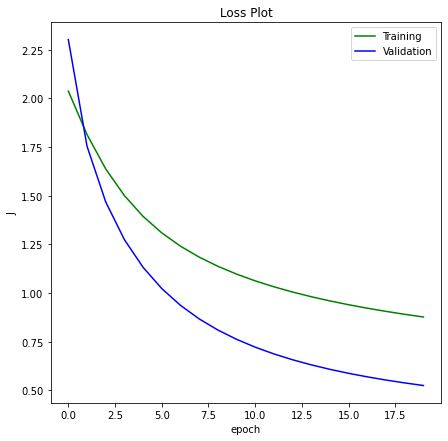

In [63]:
fig = plt.figure()
fig.set_size_inches(7, 7)
plt.plot(np.array([i for i in range(len(loss_train))]),
             loss_train, color="green", label="Training")
plt.plot(np.array([i for i in range(len(loss_v))]),
             loss_v, color="blue", label="Validation")

plt.title("Loss Plot")
plt.xlabel("epoch")
plt.ylabel("J")
plt.legend()
plt.show()